In [162]:
import openrouteservice
my_token=""
coords = ((8.34234,48.23424),(8.34423,48.26424))

client = openrouteservice.Client(key=my_token) # Specify your personal API key

# we need 2 lists because because the names for API and returned values are different

# https://giscience.github.io/openrouteservice/api-reference/endpoints/directions/extra-info/

attributes_list = [
    "surface",
    "waytype",
    "steepness",
    "tollways",
    "traildifficulty",
    "roadaccessrestrictions",
]

attribute_name = [
    "surface",
    "waytypes",
    "steepness",
    "tollways",
    "traildifficulty",
    "roadaccessrestrictions",
]
# surface
# waytypes
# steepness
# roadaccessrestrictions
# traildifficulty
# tollways


In [163]:
# mapping the points and its attributes and include the score
def calculate_route_score(option_attribute):
    """
    Calculate the score of a route based on user preferences.
    Lower scores indicate better routes.
    
    Args:
        option_attribute (dict): Attributes of a route.
        
    Returns:
        float: The score of the route.
    """
    # Get attribute arrays
    distances = np.array(option_attribute['distances'])
    steepness = np.array(option_attribute['steepness'])
    waytypes = np.array(option_attribute['waytypes'])  # Categorical, can be weighted if needed
    surfaces = np.array(option_attribute['surface'])   # Categorical, can be weighted if needed
    
    # Example scoring (modify weights as needed):
    distance_score = np.sum(distances)  # Total distance
    steepness_score = np.mean(steepness)  # Average steepness
    waytype_score = np.mean(waytypes)  # Aggregate waytype value (if needed)
    surface_score = np.mean(surfaces)  # Aggregate surface value (if needed)

    # Combine with weights (adjust based on importance)
    # score = distance_score * (steepness_score + waytype_score + surface_score)
    score = - distance_score * waytype_score

    return score
import haversine as hs
def get_linelists(route):
    linelists = []
    for i in range(len(routes['features'])):
        route = routes['features'][i]
        linelist = []
        coordinates = route['geometry']['coordinates']
        for j in range(len(coordinates)-1):
            linelist.append(hs.haversine(coordinates[j], coordinates[j+1]))
        linelists.append(linelist)
    return linelists

# get the steepness and waytype

# flatten the steepness and waytype
# steepness in ors is using run length encoding flatten is needed
def flatten_encoding(data):
    # Calculate the length of the decoded data based on the largest end index in the input
    len_data = max(part[1] for part in data)
    decoded_data = [None] * len_data

    # Populate decoded_data based on the start, end, and value in each part
    for part in data:
        start, end, value = part
        for i in range(start, end):
            decoded_data[i] = value
    return decoded_data

def flattens_attributes(routes):
    option_attributes = []
    for option_data in routes['features']:
        attributes_dict = {attr:None for attr in attribute_name}
        attributes_dict['distances'] = None
        for attr in attribute_name:
            values = option_data['properties']['extras'][attr]['values']
            values = flatten_encoding(values)
            attributes_dict[attr] = values
        coords = option_data['geometry']['coordinates']
        distances = [hs.haversine(coords[i], coords[i+1]) for i in range(len(coords)-1)]
        attributes_dict['distances'] = distances
        option_attributes.append(attributes_dict)
    route_scores = [calculate_route_score(option_attribute) for option_attribute in option_attributes]
    best_route_index = np.argmin(route_scores)
    return (option_attributes, best_route_index)

# standardize the data and prepare for training.
def standardize_data(option_attribute):
    steepness = np.array(option_attribute['steepness'])
    steepness = steepness / 5
    steepness = steepness.reshape(-1,1)
    waytypes = np.array(option_attribute['waytypes'])
    waytypes = np.eye(11)[waytypes]
    distances = np.array(option_attribute['distances'])
    distances = distances.reshape(-1,1)
    surfaces = np.array(option_attribute['surface'])
    surfaces = np.eye(19)[surfaces]
    # change the data to row
    # stacking the data
    row_data = np.hstack([steepness, waytypes, surfaces, distances])
    return row_data

In [164]:
import random
import pandas as pd
from openrouteservice.exceptions import ApiError
import json
import os
# oulubox
oulu_box = [[25.0, 64.9], [25.8, 65.2]]

# generate 100 random points in oulu box and 1000 random routes from those points

pois = pd.read_csv("data/points_of_interest_oulu_with_names.csv")
pois.columns
pois = pois[["longitude","latitude"]]
pois = pois.values.tolist()
def generate_random_routes(num_routes, points):
    # get 2 random points
    point_routes = []
    for i in range(num_routes):
        start = random.choice(points)
        end = random.choice(points)
        point_routes.append((start, end))
    return point_routes


routes = generate_random_routes(1000, pois)

# get the attributes of the routes and store in a json file
# add time sleep to avoid rate limit
import time


def query_routes(trips):
    routes = []
    count = 0
    for trip in trips:
        # flip the coordinates
        count += 1
        # this follow geojson standard [longitude, latitude]
        try:
            route = client.directions(trip,
                            profile='driving-car',
                            format='geojson',
                            extra_info=attributes_list,
                            instructions_format='html',
                            alternative_routes= {"share_factor": 0.8,"weight_factor": 2,"target_count": 3},
                            )
        except ApiError as e:
            print(e)
            continue
        time.sleep(1)
        routes.append(route)
        print(count)
    return routes
data_path = "data/routes.json"
if os.path.exists(data_path):
    with open(data_path, "r") as f:
        all_routes = json.load(f)
else:
    all_routes = query_routes(routes)
    with open(data_path, "w") as f:
        json.dump(all_routes, f)
# write all routes to a json file



In [165]:
# count number of routes that have 2 or less alternative routes
# filter out all routes that have 2 or less alternative routes
import random
counts = []
filter_routes = []
for route in all_routes:
    if len(route['features']) == 3:
        filter_routes.append(route)
print(len(filter_routes))

# get the attributes of the routes
routes_info = [flattens_attributes(route) for route in filter_routes]

# standardize the data

standardize_info = []
for options_attributes, best_route_index in routes_info:
    std_option_attributes = []
    try:
        for option_attributes in options_attributes:
            std_data = standardize_data(option_attributes)
            # check size of the data
            std_option_attributes.append(std_data)
    except Exception as e:
        print(e)
        continue
    standardize_info.append((std_option_attributes, best_route_index))

628
all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 84 and the array at index 1 has size 111
all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 157 and the array at index 1 has size 192
all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 87 and the array at index 1 has size 126
all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 10 and the array at index 1 has size 53
all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 385 and the array at index 1 has size 497


In [166]:
# design the model
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
input_size = 11 + 1 + 19
class SegmentQualityModel(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(SegmentQualityModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, 1)
    def forward(self, x, length):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = out * length
        return out
    
def user_prefer_distance(x):
    # return last column as scalar
    return x[:,-1]

In [167]:
def simulate_user_preference_distance(options_attributes):
    """
    Simulate user preference based on the total distance of routes.
    
    Args:
        options_attributes (list of list of lists): A batch of routes.
            Each route is a list of segments, where each segment is a list of attributes,
            and the first attribute is assumed to be the segment distance.
    
    Returns:
        int: The index of the user-preferred route (route with the smallest total distance).
    """
    total_distances = []  # To store total distances for each route

    for route_segments in options_attributes:
        # Calculate the total distance for the route
        total_distance = sum(segment[0] for segment in route_segments)  # Assuming distance is the first attribute
        total_distances.append(total_distance)

    # Find the index of the route with the smallest total distance
    user_preferred_route_index = torch.argmin(torch.tensor(total_distances)).item()

    return user_preferred_route_index

In [168]:
from tqdm import tqdm
batch_size = 16
num_epochs = 100
model = SegmentQualityModel(input_size, 8)
optimizer = optim.Adam(model.parameters(), lr=0.01)
margin = 1.0
# hold back 20% of the data for validation
test_size = int(len(standardize_info) * 0.2)
test_data = standardize_info[:test_size]
standardize_info = standardize_info[test_size:]
for epoch in range(num_epochs):
    random.shuffle(standardize_info)  # Shuffle the data at the start of each epoch
    for batch_start in tqdm(range(0, len(standardize_info), batch_size)):
        batch_data = standardize_info[batch_start:batch_start + batch_size]  # Get batch

        batch_loss = 0.0  # Accumulate loss for the batch

        for options_attributes, user_preferred_index in batch_data:
            score_routes = []  # List to store total scores for each route

            # Process each route in the options
            for segments in options_attributes:
                # Convert route segments to tensor
                segments_tensor = torch.tensor(segments, dtype=torch.float32)  # Shape: (num_segments, input_size)
                lengths = segments_tensor[:, -1].unsqueeze(1)  # Extract lengths as a column vector
                outputs = model(segments_tensor[:, :-1], lengths)  # Forward pass (excluding length from attributes)
                route_score = torch.sum(outputs)  # Sum segment scores for the route
                score_routes.append(route_score)

            # Stack route scores into a tensor
            score_routes_tensor = torch.stack(score_routes)  # Shape: (num_routes,)

            # Find the model-chosen best route (argmax)
            model_best_route_index = torch.argmin(score_routes_tensor).item()

            # Scores for user-chosen and model-chosen routes
            user_prefered_route_score = score_routes_tensor[user_preferred_index]  # User-chosen route score
            model_best_route_score = score_routes_tensor[model_best_route_index]  # Model-chosen route score


            # Calculate loss: Minimize the difference
            
            loss = user_prefered_route_score - model_best_route_score + margin
            batch_loss += loss

        # Backpropagation for the batch
        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()

    # Logging progress
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {batch_loss.item():.4f}")

100%|██████████| 32/32 [00:00<00:00, 173.14it/s]


Epoch [1/100], Loss: 3.0253


100%|██████████| 32/32 [00:00<00:00, 177.69it/s]


Epoch [2/100], Loss: 3.0000


100%|██████████| 32/32 [00:00<00:00, 179.65it/s]


Epoch [3/100], Loss: 3.0212


100%|██████████| 32/32 [00:00<00:00, 181.70it/s]


Epoch [4/100], Loss: 3.0058


100%|██████████| 32/32 [00:00<00:00, 179.85it/s]


Epoch [5/100], Loss: 3.0039


100%|██████████| 32/32 [00:00<00:00, 180.07it/s]


Epoch [6/100], Loss: 3.0000


100%|██████████| 32/32 [00:00<00:00, 181.56it/s]


Epoch [7/100], Loss: 3.0000


100%|██████████| 32/32 [00:00<00:00, 181.32it/s]


Epoch [8/100], Loss: 3.0000


100%|██████████| 32/32 [00:00<00:00, 181.16it/s]


Epoch [9/100], Loss: 3.0000


100%|██████████| 32/32 [00:00<00:00, 180.63it/s]


Epoch [10/100], Loss: 3.0040


100%|██████████| 32/32 [00:00<00:00, 182.68it/s]


Epoch [11/100], Loss: 3.0000


100%|██████████| 32/32 [00:00<00:00, 181.61it/s]


Epoch [12/100], Loss: 3.0002


100%|██████████| 32/32 [00:00<00:00, 153.14it/s]


Epoch [13/100], Loss: 3.0039


100%|██████████| 32/32 [00:00<00:00, 180.95it/s]


Epoch [14/100], Loss: 3.0008


100%|██████████| 32/32 [00:00<00:00, 180.74it/s]


Epoch [15/100], Loss: 3.0000


100%|██████████| 32/32 [00:00<00:00, 181.81it/s]


Epoch [16/100], Loss: 3.0009


100%|██████████| 32/32 [00:00<00:00, 181.66it/s]


Epoch [17/100], Loss: 3.0000


100%|██████████| 32/32 [00:00<00:00, 180.66it/s]


Epoch [18/100], Loss: 3.0000


100%|██████████| 32/32 [00:00<00:00, 181.20it/s]


Epoch [19/100], Loss: 3.0000


100%|██████████| 32/32 [00:00<00:00, 180.55it/s]


Epoch [20/100], Loss: 3.0000


100%|██████████| 32/32 [00:00<00:00, 180.37it/s]


Epoch [21/100], Loss: 3.0000


100%|██████████| 32/32 [00:00<00:00, 177.31it/s]


Epoch [22/100], Loss: 3.0000


100%|██████████| 32/32 [00:00<00:00, 179.93it/s]


Epoch [23/100], Loss: 3.0000


100%|██████████| 32/32 [00:00<00:00, 177.84it/s]


Epoch [24/100], Loss: 3.0000


100%|██████████| 32/32 [00:00<00:00, 180.20it/s]


Epoch [25/100], Loss: 3.0026


100%|██████████| 32/32 [00:00<00:00, 180.66it/s]


Epoch [26/100], Loss: 3.0044


100%|██████████| 32/32 [00:00<00:00, 180.57it/s]


Epoch [27/100], Loss: 3.0000


100%|██████████| 32/32 [00:00<00:00, 180.43it/s]


Epoch [28/100], Loss: 3.0082


100%|██████████| 32/32 [00:00<00:00, 181.59it/s]


Epoch [29/100], Loss: 3.0000


100%|██████████| 32/32 [00:00<00:00, 154.30it/s]


Epoch [30/100], Loss: 3.0028


100%|██████████| 32/32 [00:00<00:00, 181.99it/s]


Epoch [31/100], Loss: 3.0016


100%|██████████| 32/32 [00:00<00:00, 180.48it/s]


Epoch [32/100], Loss: 3.0000


100%|██████████| 32/32 [00:00<00:00, 182.13it/s]


Epoch [33/100], Loss: 3.0178


100%|██████████| 32/32 [00:00<00:00, 180.39it/s]


Epoch [34/100], Loss: 3.0000


100%|██████████| 32/32 [00:00<00:00, 181.89it/s]


Epoch [35/100], Loss: 3.0004


100%|██████████| 32/32 [00:00<00:00, 180.78it/s]


Epoch [36/100], Loss: 3.0011


100%|██████████| 32/32 [00:00<00:00, 180.97it/s]


Epoch [37/100], Loss: 3.0000


100%|██████████| 32/32 [00:00<00:00, 182.79it/s]


Epoch [38/100], Loss: 3.0000


100%|██████████| 32/32 [00:00<00:00, 180.80it/s]


Epoch [39/100], Loss: 3.0000


100%|██████████| 32/32 [00:00<00:00, 181.46it/s]


Epoch [40/100], Loss: 3.0000


100%|██████████| 32/32 [00:00<00:00, 180.56it/s]


Epoch [41/100], Loss: 3.0000


100%|██████████| 32/32 [00:00<00:00, 179.17it/s]


Epoch [42/100], Loss: 3.0087


100%|██████████| 32/32 [00:00<00:00, 179.63it/s]


Epoch [43/100], Loss: 3.0002


100%|██████████| 32/32 [00:00<00:00, 182.59it/s]


Epoch [44/100], Loss: 3.0012


100%|██████████| 32/32 [00:00<00:00, 180.33it/s]


Epoch [45/100], Loss: 3.0101


100%|██████████| 32/32 [00:00<00:00, 181.26it/s]


Epoch [46/100], Loss: 3.0004


100%|██████████| 32/32 [00:00<00:00, 151.96it/s]


Epoch [47/100], Loss: 3.0000


100%|██████████| 32/32 [00:00<00:00, 178.50it/s]


Epoch [48/100], Loss: 3.0000


100%|██████████| 32/32 [00:00<00:00, 180.19it/s]


Epoch [49/100], Loss: 3.0000


100%|██████████| 32/32 [00:00<00:00, 181.47it/s]


Epoch [50/100], Loss: 3.0000


100%|██████████| 32/32 [00:00<00:00, 180.71it/s]


Epoch [51/100], Loss: 3.0049


100%|██████████| 32/32 [00:00<00:00, 181.03it/s]


Epoch [52/100], Loss: 3.0000


100%|██████████| 32/32 [00:00<00:00, 181.59it/s]


Epoch [53/100], Loss: 3.0052


100%|██████████| 32/32 [00:00<00:00, 179.28it/s]


Epoch [54/100], Loss: 3.0000


100%|██████████| 32/32 [00:00<00:00, 181.32it/s]


Epoch [55/100], Loss: 3.0000


100%|██████████| 32/32 [00:00<00:00, 178.54it/s]


Epoch [56/100], Loss: 3.0000


100%|██████████| 32/32 [00:00<00:00, 177.84it/s]


Epoch [57/100], Loss: 3.0000


100%|██████████| 32/32 [00:00<00:00, 180.08it/s]


Epoch [58/100], Loss: 3.0006


100%|██████████| 32/32 [00:00<00:00, 179.28it/s]


Epoch [59/100], Loss: 3.0043


100%|██████████| 32/32 [00:00<00:00, 180.73it/s]


Epoch [60/100], Loss: 3.0010


100%|██████████| 32/32 [00:00<00:00, 180.16it/s]


Epoch [61/100], Loss: 3.0000


100%|██████████| 32/32 [00:00<00:00, 181.47it/s]


Epoch [62/100], Loss: 3.0001


100%|██████████| 32/32 [00:00<00:00, 152.48it/s]


Epoch [63/100], Loss: 3.0018


100%|██████████| 32/32 [00:00<00:00, 181.61it/s]


Epoch [64/100], Loss: 3.0000


100%|██████████| 32/32 [00:00<00:00, 180.55it/s]


Epoch [65/100], Loss: 3.0586


100%|██████████| 32/32 [00:00<00:00, 183.26it/s]


Epoch [66/100], Loss: 3.0000


100%|██████████| 32/32 [00:00<00:00, 181.39it/s]


Epoch [67/100], Loss: 3.0000


100%|██████████| 32/32 [00:00<00:00, 182.99it/s]


Epoch [68/100], Loss: 3.0038


100%|██████████| 32/32 [00:00<00:00, 182.02it/s]


Epoch [69/100], Loss: 3.0000


100%|██████████| 32/32 [00:00<00:00, 181.66it/s]


Epoch [70/100], Loss: 3.0185


100%|██████████| 32/32 [00:00<00:00, 178.62it/s]


Epoch [71/100], Loss: 3.0010


100%|██████████| 32/32 [00:00<00:00, 180.80it/s]


Epoch [72/100], Loss: 3.0003


100%|██████████| 32/32 [00:00<00:00, 179.62it/s]


Epoch [73/100], Loss: 3.0005


100%|██████████| 32/32 [00:00<00:00, 182.69it/s]


Epoch [74/100], Loss: 3.0367


100%|██████████| 32/32 [00:00<00:00, 182.37it/s]


Epoch [75/100], Loss: 3.0141


100%|██████████| 32/32 [00:00<00:00, 182.58it/s]


Epoch [76/100], Loss: 3.0022


100%|██████████| 32/32 [00:00<00:00, 182.43it/s]


Epoch [77/100], Loss: 3.0000


100%|██████████| 32/32 [00:00<00:00, 180.31it/s]


Epoch [78/100], Loss: 3.0086


100%|██████████| 32/32 [00:00<00:00, 182.78it/s]


Epoch [79/100], Loss: 3.0008


100%|██████████| 32/32 [00:00<00:00, 181.69it/s]


Epoch [80/100], Loss: 3.0000


100%|██████████| 32/32 [00:00<00:00, 152.46it/s]


Epoch [81/100], Loss: 3.0000


100%|██████████| 32/32 [00:00<00:00, 181.61it/s]


Epoch [82/100], Loss: 3.0042


100%|██████████| 32/32 [00:00<00:00, 178.93it/s]


Epoch [83/100], Loss: 3.0000


100%|██████████| 32/32 [00:00<00:00, 181.67it/s]


Epoch [84/100], Loss: 3.0000


100%|██████████| 32/32 [00:00<00:00, 181.07it/s]


Epoch [85/100], Loss: 3.0000


100%|██████████| 32/32 [00:00<00:00, 180.95it/s]


Epoch [86/100], Loss: 3.0000


100%|██████████| 32/32 [00:00<00:00, 178.80it/s]


Epoch [87/100], Loss: 3.0062


100%|██████████| 32/32 [00:00<00:00, 181.81it/s]


Epoch [88/100], Loss: 3.0032


100%|██████████| 32/32 [00:00<00:00, 180.26it/s]


Epoch [89/100], Loss: 3.0000


100%|██████████| 32/32 [00:00<00:00, 180.38it/s]


Epoch [90/100], Loss: 3.0010


100%|██████████| 32/32 [00:00<00:00, 182.25it/s]


Epoch [91/100], Loss: 3.0000


100%|██████████| 32/32 [00:00<00:00, 180.58it/s]


Epoch [92/100], Loss: 3.0000


100%|██████████| 32/32 [00:00<00:00, 180.80it/s]


Epoch [93/100], Loss: 3.0018


100%|██████████| 32/32 [00:00<00:00, 182.21it/s]


Epoch [94/100], Loss: 3.0000


100%|██████████| 32/32 [00:00<00:00, 180.04it/s]


Epoch [95/100], Loss: 3.0000


100%|██████████| 32/32 [00:00<00:00, 181.65it/s]


Epoch [96/100], Loss: 3.0032


100%|██████████| 32/32 [00:00<00:00, 179.91it/s]


Epoch [97/100], Loss: 3.0000


100%|██████████| 32/32 [00:00<00:00, 180.35it/s]


Epoch [98/100], Loss: 3.0006


100%|██████████| 32/32 [00:00<00:00, 182.45it/s]


Epoch [99/100], Loss: 3.0029


100%|██████████| 32/32 [00:00<00:00, 152.14it/s]

Epoch [100/100], Loss: 3.0101


In [169]:
# Testing loop to calculate accuracy
print("\nStarting testing...")
correct_predictions = 0  # Count of correct predictions
total_samples = len(test_data)  # Total number of test samples

with torch.no_grad():  # No gradient updates during testing
    for options_attributes, user_preferred_index in tqdm(test_data):
        score_routes = []  # List to store total scores for each route

        # Process each route in the options
        for segments in options_attributes:
            segments_tensor = torch.tensor(segments, dtype=torch.float32)  # Shape: (num_segments, input_size)
            lengths = segments_tensor[:, -1].unsqueeze(1)  # Extract lengths as a column vector
            outputs = model(segments_tensor[:, :-1], lengths)  # Forward pass
            route_score = torch.sum(outputs)  # Sum segment scores for the route
            score_routes.append(route_score)

        # Stack route scores into a tensor
        score_routes_tensor = torch.stack(score_routes)  # Shape: (num_routes,)

        # Find the model-chosen best route (argmin)
        model_best_route_index = torch.argmin(score_routes_tensor).item()

        # Check if the model's choice matches the user's preferred route
        if model_best_route_index == user_preferred_index:
            correct_predictions += 1

# Calculate accuracy
accuracy = (correct_predictions / total_samples) * 100
print(f"Test Accuracy: {accuracy:.2f}%")


Starting testing...


100%|██████████| 124/124 [00:00<00:00, 5428.78it/s]

Test Accuracy: 87.90%


Testing: 100%|██████████| 475/475 [00:00<00:00, 6752.05it/s]


Testing Data Count: 24 samples, Accuracy: 80.84%


Testing: 100%|██████████| 275/275 [00:00<00:00, 6082.32it/s]


Testing Data Count: 224 samples, Accuracy: 80.00%


Testing: 100%|██████████| 75/75 [00:00<00:00, 5990.49it/s]


Testing Data Count: 424 samples, Accuracy: 82.67%


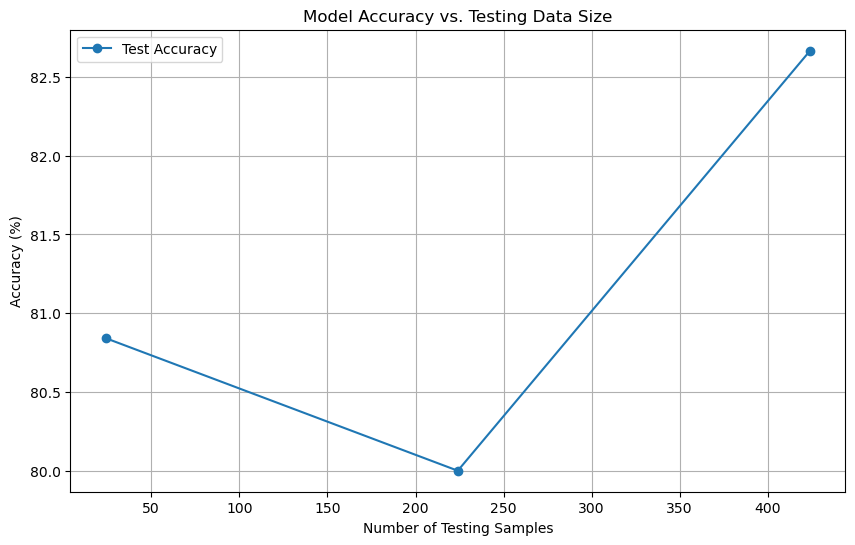

In [170]:
import matplotlib.pyplot as plt

def train_and_test_model(data, input_size, model_class, train_percentage, batch_size=16, num_epochs=100, lr=0.01, margin=1.0):
    """
    Trains and evaluates a segment scoring model based on provided data.
    
    Args:
        data: The dataset to be split and used for training and testing.
        input_size: The size of the input features for the model.
        model_class: The class defining the neural network model.
        percentage: Percentage of the original data to use for testing.
        batch_size: Size of each training batch.
        num_epochs: Number of training epochs.
        lr: Learning rate for the optimizer.
        margin: Margin used in the loss function.
    
    Returns:
        A tuple containing test accuracy and number of test samples.
    """
    # Split the data
    
    train_size = int(len(data) * (train_percentage / 100))
    train_data = data[:train_size]
    test_data = data[train_size:]


    # Initialize model, optimizer
    model = model_class(input_size, 8)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    # Training loop
    for epoch in range(num_epochs):
        random.shuffle(train_data)  # Shuffle the training data
        for batch_start in tqdm(range(0, len(train_data), batch_size), desc=f"Epoch {epoch+1}"):
            batch_data = train_data[batch_start:batch_start + batch_size]  # Get batch
            batch_loss = 0.0

            for options_attributes, user_preferred_index in batch_data:
                score_routes = []
                for segments in options_attributes:
                    segments_tensor = torch.tensor(segments, dtype=torch.float32)
                    lengths = segments_tensor[:, -1].unsqueeze(1)
                    outputs = model(segments_tensor[:, :-1], lengths)
                    route_score = torch.sum(outputs)
                    score_routes.append(route_score)
                
                score_routes_tensor = torch.stack(score_routes)
                user_prefered_route_score = score_routes_tensor[user_preferred_index]
                model_best_route_score = score_routes_tensor[torch.argmin(score_routes_tensor).item()]
                
                # Calculate loss
                loss = user_prefered_route_score - model_best_route_score + margin
                batch_loss += loss

            # Backpropagation for the batch
            optimizer.zero_grad()
            batch_loss.backward()
            optimizer.step()
    
    # Testing loop
    correct_predictions = 0
    with torch.no_grad():
        for options_attributes, user_preferred_index in tqdm(test_data, desc="Testing"):
            score_routes = []
            for segments in options_attributes:
                segments_tensor = torch.tensor(segments, dtype=torch.float32)
                lengths = segments_tensor[:, -1].unsqueeze(1)
                outputs = model(segments_tensor[:, :-1], lengths)
                route_score = torch.sum(outputs)
                score_routes.append(route_score)
            
            score_routes_tensor = torch.stack(score_routes)
            model_best_route_index = torch.argmin(score_routes_tensor).item()
            if model_best_route_index == user_preferred_index:
                correct_predictions += 1
    
    accuracy = (correct_predictions / len(test_data)) * 100
    return accuracy, train_size, model

def evaluate_model(data, input_size, model_class, percentages, batch_size=16, num_epochs=100, lr=0.01, margin=1.0):
    """
    Evaluates the model for various test data percentages and plots the results based on actual data size.
    
    Args:
        data: The dataset to be split and used for training and testing.
        input_size: The size of the input features for the model.
        model_class: The class defining the neural network model.
        percentages: A list of percentages of data to use for testing.
    
    Returns:
        None
    """
    results = []
    for percentage in percentages:
        accuracy, test_size, _ = train_and_test_model(
            data, input_size, model_class, percentage, 
            batch_size=batch_size, num_epochs=num_epochs, lr=lr, margin=margin
        )
        results.append((test_size, accuracy))
        print(f"Testing Data Count: {test_size} samples, Accuracy: {accuracy:.2f}%")
    
    # Plotting the results
    train_sizes, accuracies = zip(*results)
    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, accuracies, marker='o', linestyle='-', label='Test Accuracy')
    plt.title("Model Accuracy vs. Testing Data Size")
    plt.xlabel("Number of Testing Samples")
    plt.ylabel("Accuracy (%)")
    plt.grid()
    plt.legend()
    plt.show()

# Specify percentages
percentages = range(5, 96, 40)

evaluate_model(standardize_info, input_size, SegmentQualityModel, percentages)


In [171]:
_,_,model = train_and_test_model(standardize_info, input_size, SegmentQualityModel, 80, batch_size=16, num_epochs=100, lr=0.01, margin=1.0) 

Testing: 100%|██████████| 100/100 [00:00<00:00, 6019.29it/s]


In [172]:
def predict_best_route(model, start, end , openrouteservice_client):
    start = (start[1], start[0])
    end = (end[1], end[0])

    route_info = openrouteservice_client.directions(
        (start, end),
        profile='driving-car',
        format='geojson',
        extra_info=attributes_list,
        instructions_format='html',
        alternative_routes= {"share_factor": 0.8,"weight_factor": 2,"target_count": 3},
    )
    # parse the route info
    option_attributes, best_route_index = flattens_attributes(route_info)
    # standardize the data
    std_option_attributes = [standardize_data(option) for option in option_attributes]
    # get score for each route
    score_routes = []
    for segments in std_option_attributes:
        segments_tensor = torch.tensor(segments, dtype=torch.float32)
        lengths = segments_tensor[:, -1].unsqueeze(1)
        outputs = model(segments_tensor[:, :-1], lengths)
        route_score = torch.sum(outputs)
        score_routes.append(route_score)
    best_route_index = torch.argmin(torch.stack(score_routes)).item()
    return best_route_index, score_routes


predict_best_route(model, start, end, client)

(0,
 [tensor(-0.1160, grad_fn=<SumBackward0>),
  tensor(-0.0947, grad_fn=<SumBackward0>),
  tensor(-0.1137, grad_fn=<SumBackward0>)])

In [173]:
import folium

start = (65.062795, 25.472358)  # Example: London (longitude, latitude)
end = (65.013059, 25.485466)  # Example: near to Big Ben, London

# Get the route from OpenRouteService API

client_start = (start[1], start[0])
client_end = (end[1], end[0])
routes = client.directions(
    (client_start,client_end),  # Start and end coordinates
    profile='driving-car',  # Transportation type
    alternative_routes= {"share_factor": 0.8,"weight_factor": 2,"target_count": 3},  # Request up to 3 alternative routes
    format='geojson'
)
best_route_index, score_routes = predict_best_route(model, start, end, client)
print(score_routes)
# Initialize a folium map centered on the starting point

m = folium.Map(location=start, zoom_start=14)

# Add the route to the map
chosen_route = routes['features'][best_route_index]
folium.GeoJson(chosen_route).add_to(m)
# folium.GeoJson(routes).add_to(m)

# Add markers for start and end points
folium.Marker(location=start, popup='Start: London').add_to(m)
folium.Marker(location=end, popup='End: Big Ben').add_to(m)

# Save the map to an HTML file
m.save('route_map.html')

[tensor(-0.1160, grad_fn=<SumBackward0>), tensor(-0.0947, grad_fn=<SumBackward0>), tensor(-0.1137, grad_fn=<SumBackward0>)]
